In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import seaborn as sn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, Flatten, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, CSVLogger

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Reading Data

In [ ]:
# Reading data from csv file
data = pd.read_csv("/content/drive/MyDrive/sem9/data.csv")
data.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


In [ ]:
data.shape

(420464, 2)

In [ ]:
data['label'].unique()

array(['bad', 'good'], dtype=object)

### Data Preprocessing

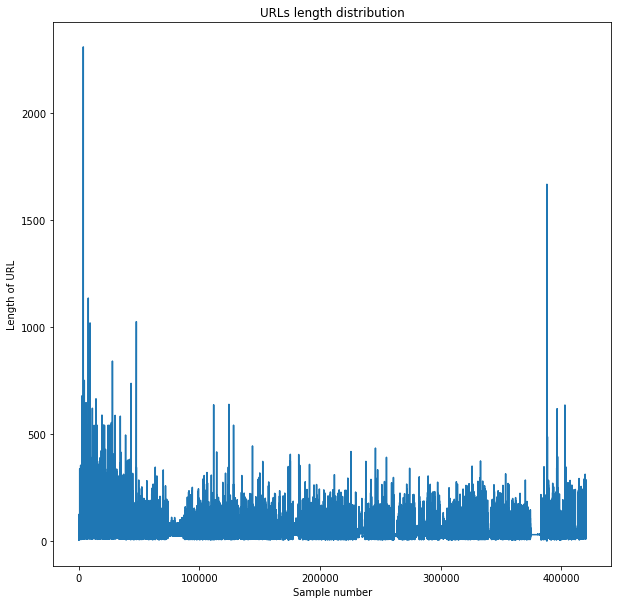

In [ ]:
def plot_sample_length_distribution(urls):
    plt.figure(figsize=(10,10))
    plt.plot([x for x in range(len(urls))], [len(s) for s in urls])
#     plt.hist([len(s) for s in urls], 50)
    plt.xlabel('Sample number')
    plt.ylabel('Length of URL')
    plt.title('URLs length distribution')
    plt.show()

plot_sample_length_distribution(data['url'])

#### malicious = 1 <br> Normal = 0

In [ ]:
data['label'] = np.where(data['label']=='bad',1,0)

In [ ]:
data['label'].value_counts()

0    344821
1     75643
Name: label, dtype: int64

## Balancing the data

### 1. Performing under sampling

In [ ]:
df0_count, df1_count = data['label'].value_counts()

In [ ]:
# divide by class
df0 = data[data['label'] == 0]
df1 = data[data['label'] == 1]

In [ ]:
df0.shape

(344821, 2)

In [ ]:
df1.shape

(75643, 2)

In [ ]:
df0_under = df0.sample(df1_count)

In [ ]:
data_balanced_under_sampling = pd.concat([df0_under, df1], axis=0)

In [ ]:
data_balanced_under_sampling = data_balanced_under_sampling.sample(frac=1) 
data_balanced_under_sampling

,url,label
322556,punknews.org/bands/eastbayrayandthekillersmiles,0
130972,people.famouswhy.com/tony_potts/,0
304093,myspace.com/mrs_mother,0
374317,youthradio.org/oldsite/books/001024_shiga.shtml,0
32095,plavcd.com/a/1d0f89c22f3a270341dcd7e347092c62/,1
...,...,...
418942,222.239.91.18:127/anxiaomo32,1
9754,xn--80adkrdepdg.xn--p1ai/logn/box/dropbox/,1
406429,swadsexto.com/1imkfsu,1
53367,biology.caltech.edu/Members/Koch,0


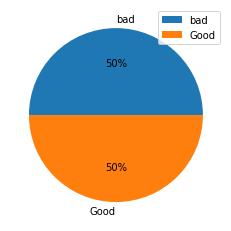

In [ ]:
counts = data_balanced_under_sampling.groupby(['label']).size()

plt.pie(counts, labels = ['bad', 'Good'], autopct='%.0f%%')
plt.legend()


In [ ]:
# split data in test, train and validation

train_dataset, temp_test_dataset =  train_test_split(data_balanced_under_sampling, test_size=0.4)
test_dataset, valid_dataset =  train_test_split(temp_test_dataset, test_size=0.5)


In [ ]:
X_train = train_dataset['url']
y_train = train_dataset['label']

X_test = test_dataset['url']
y_test = test_dataset['label']

X_valid = valid_dataset['url']
y_valid = valid_dataset['label']

# Using count vectorizer

In [ ]:
cv = CountVectorizer(max_features=1000)

# creating vectors for traning data
X_train_cv = cv.fit_transform(X_train)
# creating vectors for testing data
X_test_cv = cv.transform(X_test)
X_valid_cv = cv.transform(X_valid)

In [ ]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 1000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [ ]:
y_train.shape

(90771,)

In [ ]:
X_train_cv = X_train_cv.toarray()
X_test_cv = X_test_cv.toarray()
X_valid_cv = X_valid_cv.toarray()

y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()


## Test for Neural network Architecture

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def create_model(layers , activation):
  model = Sequential()
  for i, nodes in enumerate(layers):
    if i==0:
      model.add(Dense(nodes, input_dim=X_train_cv.shape[1]))
      model.add(Activation(activation))
    else:
      model.add(Dense(nodes))
      model.add(Activation(activation))
  
  model.add(Dense(1))
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model
  
model_test = KerasClassifier(build_fn=create_model, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
layers = [[32,64], [64,32,64], [32, 64, 32]]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size=[128,256], epochs=[30])
grid = GridSearchCV(estimator=model_test, param_grid=param_grid)

In [ ]:
grid_result = grid.fit(X_train_cv, y_train)

In [ ]:
grid_result.best_

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa93856e550>,
             param_grid={'activation': ['sigmoid', 'relu'],
                         'batch_size': [128, 256], 'epochs': [30],
                         'layers': [[32, 64], [64, 32, 64], [32, 64, 32]]})

In [ ]:
[grid_result.best_score_, grid_result.best_params_]

[0.8970045685768128,
 {'activation': 'relu', 'batch_size': 128, 'epochs': 30, 'layers': [32, 64]}]

## Using Neural Network

In [ ]:
# We decalred a function for creating a model.
def build_model():
    model = Sequential()

    # Input Layer with 32 Neurons
    model.add(Dense(32, input_shape = (X_train_cv.shape[1],)))    # Input layer => input_shape must be explicitly designated
      
    
    model.add(Dense(64, activation='relu'))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    # Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp, etc. # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    learning_rate = 0.001
    optimizer = optimizers.Adam(learning_rate)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=optimizer,
                metrics=['accuracy']) 
    return model

EPOCHS = 100
batch_size = 128 

model = build_model()
model.summary()


plot_model(model, 'model.png', show_shapes=True)

#callbacks: checkpoint, csv_logger
filepath="model1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
csv_log=CSVLogger('model_log.csv',separator=',',append=False)
callbacks_list=[checkpoint,csv_log]



# with tf.device('/GPU:0'): # comment the previous line and uncomment this line to train with a GPU, if available.
history = model.fit(
    X_train_cv, 
    y_train,
    batch_size = batch_size,
    epochs=EPOCHS, 
    verbose=1,
    shuffle=True,
    steps_per_epoch = int(X_train_cv.shape[0] / batch_size) ,
    validation_data = (X_valid_cv, y_valid),
    callbacks=callbacks_list
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                32032     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
701/709 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.8598
Epoch 1: val_accuracy improved from -inf to 0.88658, saving model to model1.hdf5
709/709 [==============================] - 6s 5ms/step - loss: 0.2612 - accuracy: 0.8600 - val_loss: 0.2221 - val_accuracy: 0.8866
Epoch 2

In [ ]:
print('Summary of the results after each epoch: ')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Summary of the results after each epoch: 


,loss,accuracy,val_loss,val_accuracy,epoch
95,0.155674,0.909579,0.255184,0.893152,95
96,0.156763,0.908597,0.252863,0.889484,96
97,0.156283,0.910241,0.253518,0.893317,97
98,0.155007,0.909778,0.253286,0.892623,98
99,0.157208,0.908013,0.253344,0.893185,99


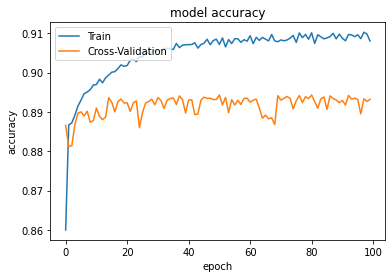

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

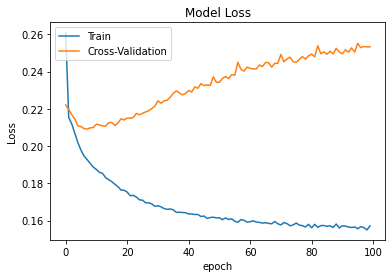

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

In [ ]:
print('Train Split: ')
loss, accuracy = model.evaluate(X_train_cv, y_train, verbose=1)
print("Accuracy   : {:5.2f} ".format(accuracy))

print('Evaluation Split: ')
loss, accuracy =  model.evaluate(X_valid_cv, y_valid, verbose=2)
print("Accuracy   : {:5.2f} ".format(accuracy))

print('Test Split: ')
loss, accuracy =  model.evaluate(X_test_cv, y_test, verbose=2)
print("Accuracy   : {:5.2f} ".format(accuracy))

Train Split: 
2837/2837 [==============================] - 6s 2ms/step - loss: 0.1539 - accuracy: 0.9107
Accuracy   :  0.91 
Evaluation Split: 
946/946 - 2s - loss: 0.2533 - accuracy: 0.8932 - 2s/epoch - 2ms/step
Accuracy   :  0.89 
Test Split: 
946/946 - 2s - loss: 0.2434 - accuracy: 0.8948 - 2s/epoch - 2ms/step
Accuracy   :  0.89 


946/946 [==============================] - 1s 1ms/step
Accuracy of ANN model is:  0.8948012030273986

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     14916
           1       0.96      0.83      0.89     15341

    accuracy                           0.89     30257
   macro avg       0.90      0.90      0.89     30257
weighted avg       0.90      0.89      0.89     30257



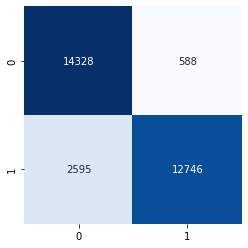

In [ ]:
prob = model.predict(X_test_cv)

ann_pred=(prob > 0.5).astype('int')

cm = confusion_matrix(y_test, ann_pred)
ac = accuracy_score(y_test, ann_pred)
# Accuracy of Our Model
print("Accuracy of ANN model is: ",ac)
print()
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

print(classification_report(y_test, ann_pred))

In [ ]:
cv_results = []
cv_results.append(('Classifier','Accurary','Precision', 'Recall','F1-Score'))

In [ ]:
cv_results.append(("ANN ", accuracy_score(y_test,  ann_pred)*100,
                precision_score(y_test,  ann_pred)*100,
                recall_score(y_test,  ann_pred)*100,
                f1_score(y_test,  ann_pred)*100 ))

### Visualize neural Network

In [ ]:
!pip install ann_visualizer
!pip install graphviz
!pip install h5py

In [ ]:
from ann_visualizer.visualize import ann_viz;
from keras.models import model_from_json

In [ ]:
model = model_from_json(model.to_json())
# load weights into new model
model.load_weights("/content/model1.hdf5")
ann_viz(model, title="Artificial Neural network - Model Visualization")

### logistic regression

In [ ]:
# Model Building using logistic regression
logit = LogisticRegression()
logit.fit(X_train_cv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Accuracy of Logistic Regression model is:  0.8898106223353274

              precision    recall  f1-score   support

           0       0.85      0.95      0.89     14916
           1       0.94      0.83      0.88     15341

    accuracy                           0.89     30257
   macro avg       0.89      0.89      0.89     30257
weighted avg       0.90      0.89      0.89     30257



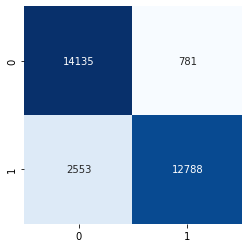

In [ ]:
logit_cv_pred = logit.predict(X_test_cv)

cm = confusion_matrix(y_test, logit_cv_pred)
ac = accuracy_score(y_test, logit_cv_pred)
# Accuracy of Our Model
print("Accuracy of Logistic Regression model is: ",ac)
print()
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

print(classification_report(y_test, logit_cv_pred))

In [ ]:
cv_results.append(("LogR ", accuracy_score(y_test,  logit_cv_pred)*100,
                precision_score(y_test,  logit_cv_pred)*100,
                recall_score(y_test,  logit_cv_pred)*100,
                f1_score(y_test,  logit_cv_pred)*100 ))

In [ ]:
cv_results

[('Classifier', 'Accurary', 'Precision', 'Recall', 'F1-Score'),
 ('ANN ',
  89.48012030273986,
  95.59022048897555,
  83.08454468417965,
  88.89973844812556),
 ('LogR ',
  88.98106223353274,
  94.24423317856879,
  83.35832083958022,
  88.46765824974058)]

### Applying Naive Bayes

Accuracy of Naive Bayes model is:  0.925639500297442
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     15129
           1       0.96      0.89      0.92     15129

    accuracy                           0.93     30258
   macro avg       0.93      0.93      0.93     30258
weighted avg       0.93      0.93      0.93     30258



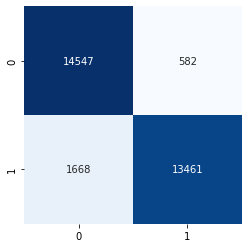

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_cv, y_train)

mnb_cv_pred = mnb.predict(X_test_cv)

cm = confusion_matrix(y_test, mnb_cv_pred)
ac = accuracy_score(y_test, mnb_cv_pred)
# Accuracy of Our Model
print("Accuracy of Naive Bayes model is: ",ac)

# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

print(classification_report(y_test, mnb_cv_pred))

In [ ]:
cv_results.append(("MNB ", accuracy_score(y_test,  mnb_cv_pred)*100,
                precision_score(y_test,  mnb_cv_pred)*100,
                recall_score(y_test,  mnb_cv_pred)*100,
                f1_score(y_test,  mnb_cv_pred)*100 ))

### Applying Decision Tree

Accuracy of Decision Tree model is:  0.922169343644656
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     15129
           1       0.95      0.89      0.92     15129

    accuracy                           0.92     30258
   macro avg       0.92      0.92      0.92     30258
weighted avg       0.92      0.92      0.92     30258



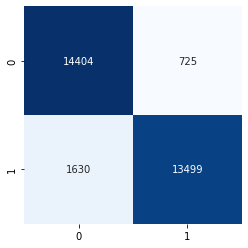

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train_cv, y_train)

dt_cv_pred = dtc.predict(X_test_cv)

cm = confusion_matrix(y_test, dt_cv_pred)
ac = accuracy_score(y_test, dt_cv_pred)
# Accuracy of Our Model
print("Accuracy of Decision Tree model is: ",ac)

# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

print(classification_report(y_test, dt_cv_pred))

In [ ]:
cv_results.append(("DT ", accuracy_score(y_test,  dt_cv_pred)*100,
                precision_score(y_test,  dt_cv_pred)*100,
                recall_score(y_test,  dt_cv_pred)*100,
                f1_score(y_test,  dt_cv_pred)*100 ))

In [ ]:
pd.DataFrame(cv_results)

,0,1,2,3,4
0,Classifier,Accurary,Precision,Recall,F1-Score
1,LogR,93.198493,96.387252,89.761385,92.956397
2,MNB,92.56395,95.855586,88.974817,92.287125
3,DT,92.216934,94.902981,89.22599,91.97697


# Creating TF-IDF Vectors 

In [ ]:
X_train = train_dataset['url']
y_train = train_dataset['label']

X_test = test_dataset['url']
y_test = test_dataset['label']

X_valid = valid_dataset['url']
y_valid = valid_dataset['label']

In [ ]:
# Using Tokenizer
vectorizer = TfidfVectorizer(max_features=1000)

# creating tf-idf vectors for traning data
X_train_tf_idf = vectorizer.fit_transform(X_train)
# creating tf-idf vectors for testing data
X_test_tf_idf = vectorizer.transform(X_test)
X_valid_tf_idf = vectorizer.transform(X_valid)

In [ ]:
X_train_tf_idf = X_train_tf_idf.toarray()
X_test_tf_idf = X_test_tf_idf.toarray()
X_valid_tf_idf = X_valid_tf_idf.toarray()

y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()


In [ ]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 1000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [ ]:
tf_idf_results = []
tf_idf_results.append(('Classifier','Accurary','Precision', 'Recall','F1-Score'))

### ANN

In [ ]:
# We decalred a function for creating a model.
def build_model():
    model = Sequential()

    # Input Layer with 32 Neurons
    model.add(Dense(32, input_shape = (X_train_tf_idf.shape[1],)))    # Input layer => input_shape must be explicitly designated
      
    
    model.add(Dense(64, activation='relu'))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    # Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp, etc. # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    learning_rate = 0.001
    optimizer = optimizers.Adam(learning_rate)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=optimizer,
                metrics=['accuracy']) 
    return model

EPOCHS = 100
batch_size = 128 

model = build_model()
model.summary()


plot_model(model, 'model2.png', show_shapes=True)

#callbacks: checkpoint, csv_logger
filepath="model1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
csv_log=CSVLogger('model_log2.csv',separator=',',append=False)
callbacks_list=[checkpoint,csv_log]



# with tf.device('/GPU:0'): # comment the previous line and uncomment this line to train with a GPU, if available.
history = model.fit(
    X_train_tf_idf, 
    y_train,
    batch_size = batch_size,
    epochs=EPOCHS, 
    verbose=1,
    shuffle=True,
    steps_per_epoch = int(X_train_tf_idf.shape[0] / batch_size) ,
    validation_data = (X_valid_tf_idf, y_valid),
    callbacks=callbacks_list
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                32032     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
705/709 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.8544
Epoch 1: val_accuracy improved from -inf to 0.88558, saving model to model1.hdf5
709/709 [==============================] - 10s 7ms/step - loss: 0.2694 - accuracy: 0.8546 - val_loss: 0.2224 - val_accuracy: 0.8856
Epoc

In [ ]:
print('Summary of the results after each epoch: ')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Summary of the results after each epoch: 


,loss,accuracy,val_loss,val_accuracy,epoch
95,0.159900,0.908509,0.236254,0.893251,95
96,0.159655,0.908686,0.238022,0.890211,96
97,0.160483,0.906921,0.238451,0.893780,97
98,0.159546,0.908984,0.237565,0.892954,98
99,0.159982,0.907428,0.238396,0.893549,99


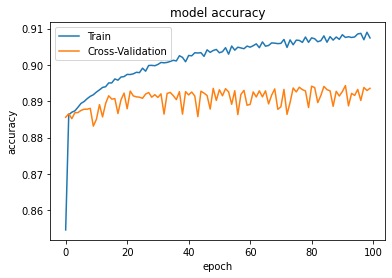

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

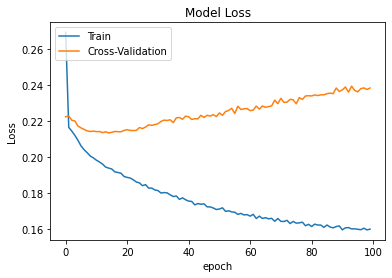

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

In [ ]:
print('Train Split: ')
loss, accuracy = model.evaluate(X_train_tf_idf, y_train, verbose=1)
print("Accuracy   : {:5.2f} ".format(accuracy))

print('Evaluation Split: ')
loss, accuracy =  model.evaluate(X_valid_tf_idf, y_valid, verbose=2)
print("Accuracy   : {:5.2f} ".format(accuracy))

print('Test Split: ')
loss, accuracy =  model.evaluate(X_test_tf_idf, y_test, verbose=2)
print("Accuracy   : {:5.2f} ".format(accuracy))

Train Split: 
2837/2837 [==============================] - 6s 2ms/step - loss: 0.1570 - accuracy: 0.9101
Accuracy   :  0.91 
Evaluation Split: 
946/946 - 2s - loss: 0.2384 - accuracy: 0.8935 - 2s/epoch - 2ms/step
Accuracy   :  0.89 
Test Split: 
946/946 - 2s - loss: 0.2416 - accuracy: 0.8938 - 2s/epoch - 2ms/step
Accuracy   :  0.89 


In [ ]:
model.pedict(X_test)

NameError: ignored

### Applying Logistic Regression

In [ ]:
# Model Building using logistic regression
logit = LogisticRegression()
logit.fit(X_train_tf_idf, y_train)

c:\Users\ritik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
logit_tf_idf_pred = logit.predict(X_test_tf_idf)

In [ ]:
cm = confusion_matrix(y_test, logit_tf_idf_pred)
ac = accuracy_score(y_test, logit_tf_idf_pred)
# Accuracy of Our Model
print("Accuracy of Logistic Regression model is: ",ac)

Accuracy of Logistic Regression model is:  0.9316874876065834


<AxesSubplot:>

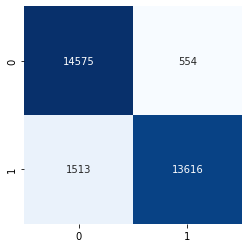

In [ ]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [ ]:
print(classification_report(y_test, logit_tf_idf_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     15129
           1       0.96      0.90      0.93     15129

    accuracy                           0.93     30258
   macro avg       0.93      0.93      0.93     30258
weighted avg       0.93      0.93      0.93     30258



In [ ]:
tf_idf_results.append(("LogR ", accuracy_score(y_test,  logit_tf_idf_pred)*100,
                precision_score(y_test,  logit_tf_idf_pred)*100,
                recall_score(y_test,  logit_tf_idf_pred)*100,
                f1_score(y_test,  logit_tf_idf_pred)*100 ))


### Applying Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tf_idf, y_train)

MultinomialNB()

In [ ]:
mnb_tf_idf_pred = mnb.predict(X_test_tf_idf)

In [ ]:
cm = confusion_matrix(y_test, mnb_tf_idf_pred)
ac = accuracy_score(y_test, mnb_tf_idf_pred)
# Accuracy of Our Model
print("Accuracy of SVM model is: ",ac)

Accuracy of SVM model is:  0.9289113622843546


<AxesSubplot:>

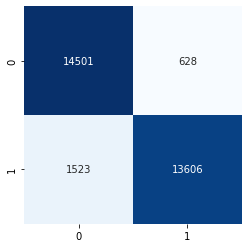

In [ ]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [ ]:
print(classification_report(y_test, mnb_tf_idf_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     15129
           1       0.96      0.90      0.93     15129

    accuracy                           0.93     30258
   macro avg       0.93      0.93      0.93     30258
weighted avg       0.93      0.93      0.93     30258



In [ ]:
tf_idf_results.append(("MNB ", accuracy_score(y_test,  mnb_tf_idf_pred)*100,
                precision_score(y_test,  mnb_tf_idf_pred)*100,
                recall_score(y_test,  mnb_tf_idf_pred)*100,
                f1_score(y_test,  mnb_tf_idf_pred)*100 ))


### Applying Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train_tf_idf, y_train)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
dt_tf_idf_pred = dtc.predict(X_test_tf_idf)

In [ ]:
cm = confusion_matrix(y_test, dt_tf_idf_pred)
ac = accuracy_score(y_test, dt_tf_idf_pred)
# Accuracy of Our Model
print("Accuracy of SVM model is: ",ac)

Accuracy of SVM model is:  0.9134113292352436


<AxesSubplot:>

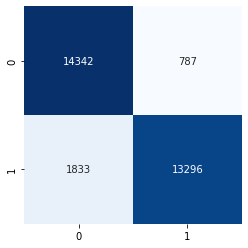

In [ ]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [ ]:
print(classification_report(y_test, dt_tf_idf_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     15129
           1       0.94      0.88      0.91     15129

    accuracy                           0.91     30258
   macro avg       0.92      0.91      0.91     30258
weighted avg       0.92      0.91      0.91     30258



In [ ]:
tf_idf_results.append(("DT ", accuracy_score(y_test,  dt_tf_idf_pred)*100,
                precision_score(y_test,  dt_tf_idf_pred)*100,
                recall_score(y_test,  dt_tf_idf_pred)*100,
                f1_score(y_test,  dt_tf_idf_pred)*100 ))


In [ ]:
pd.DataFrame(tf_idf_results)

,0,1,2,3,4
0,Classifier,Accurary,Precision,Recall,F1-Score
1,LogR,93.168749,96.090332,89.999339,92.945152
2,MNB,92.891136,95.588029,89.933241,92.674454
3,DT,91.341133,94.411702,87.884196,91.031083


### Visualize Results

#### CountVectorizer

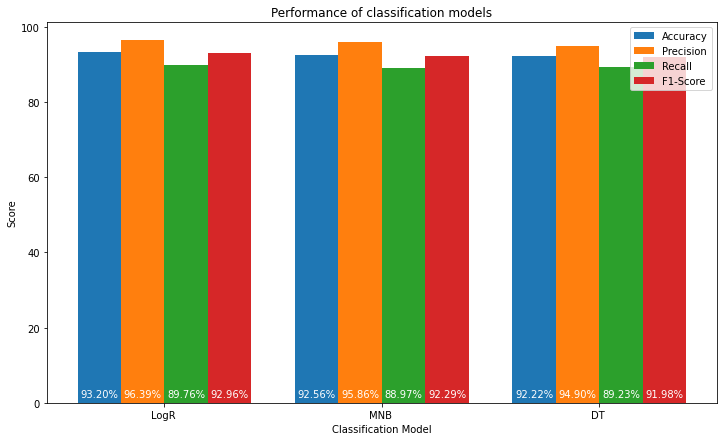

In [ ]:
plt.figure(figsize=(12,7))
X_axis = np.arange(len(cv_results)-1)
models_name = [x[0] for x in cv_results[1:]]

accuracy_list = [x[1] for x in cv_results[1:]]
precision_list = [x[2] for x in cv_results[1:]]
recall_list = [x[3] for x in cv_results[1:]]
f1_list = [x[4] for x in cv_results[1:]]


p1 = plt.bar(X_axis - 0.3, accuracy_list, 0.2, label = 'Accuracy')
for rect in p1:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p2 = plt.bar(X_axis - 0.1, precision_list, 0.2, label = 'Precision')
for rect in p2:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p3 = plt.bar(X_axis + 0.1, recall_list, 0.2, label = 'Recall')
for rect in p3:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p4 = plt.bar(X_axis + 0.3, f1_list, 0.2, label = 'F1-Score')
for rect in p4:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')


plt.xticks(X_axis, models_name)
plt.xlabel("Classification Model")
plt.ylabel("Score")
plt.title("Performance of classification models")
plt.legend(loc='upper right')
plt.show()

#### TFIDF Vectorizer

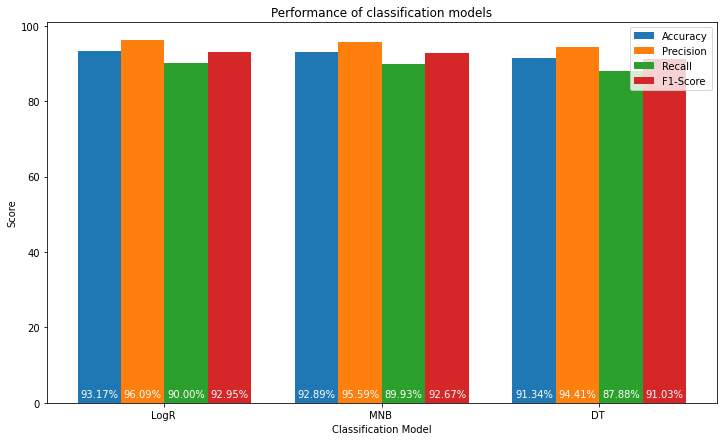

In [ ]:
plt.figure(figsize=(12,7))
X_axis = np.arange(len(tf_idf_results)-1)
models_name = [x[0] for x in tf_idf_results[1:]]

accuracy_list = [x[1] for x in tf_idf_results[1:]]
precision_list = [x[2] for x in tf_idf_results[1:]]
recall_list = [x[3] for x in tf_idf_results[1:]]
f1_list = [x[4] for x in tf_idf_results[1:]]


p1 = plt.bar(X_axis - 0.3, accuracy_list, 0.2, label = 'Accuracy')
for rect in p1:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p2 = plt.bar(X_axis - 0.1, precision_list, 0.2, label = 'Precision')
for rect in p2:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p3 = plt.bar(X_axis + 0.1, recall_list, 0.2, label = 'Recall')
for rect in p3:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p4 = plt.bar(X_axis + 0.3, f1_list, 0.2, label = 'F1-Score')
for rect in p4:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')


plt.xticks(X_axis, models_name)
plt.xlabel("Classification Model")
plt.ylabel("Score")
plt.title("Performance of classification models")
plt.legend(loc='upper right')
plt.show()